In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
from tqdm import tqdm

/kaggle/input/salary-nlp-tt/vacancies_test.csv
/kaggle/input/salary-nlp-tt/vacancies_train.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/salary-nlp-tt/vacancies_train.csv')
test_df = pd.read_csv('/kaggle/input/salary-nlp-tt/vacancies_test.csv')

In [3]:
train_df.tail(5)

,name,experience,schedule,employment,description,key_skills,salary
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0
16628,Специалист-эксперт отдела правового обеспечения,Нет опыта,Полный день,Полная занятость,Обязанности: правовое сопровождение деятельно...,"['Грамотная речь', 'Пользователь ПК', 'Умение ...",25000.0


In [4]:
test_df.tail(5)

,id,name,experience,schedule,employment,description,key_skills
5538,5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['Удаленная работа', 'Грамотная речь', 'Пользо..."
5539,5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['Пользователь ПК', 'Розничная торговля', 'Раб..."
5540,5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[]
5541,5541,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Мечтаешь быть уникальной? Хочешь дарить клиент...,"['Работа в команде', 'Грамотная речь', 'Ориент..."
5542,5542,"Торговый представитель (Колпино, Тосно, Кировск)",От 1 года до 3 лет,Полный день,Полная занятость,Компания ТД Мегаполис - крупный дистрибьютор п...,"['Традиционная розница', 'работа с текущей баз..."


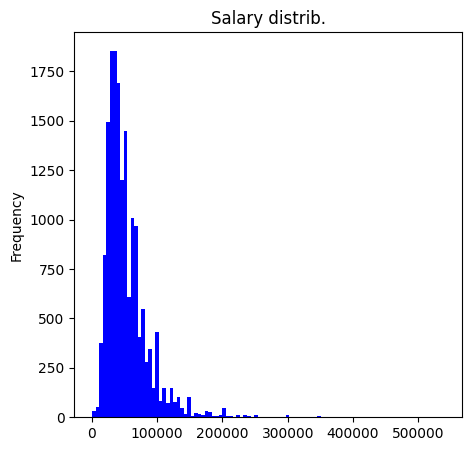

In [5]:
plt.title("Salary distrib.")
train_df['salary'].plot.hist(bins= 100, color='b', figsize=(5,5));

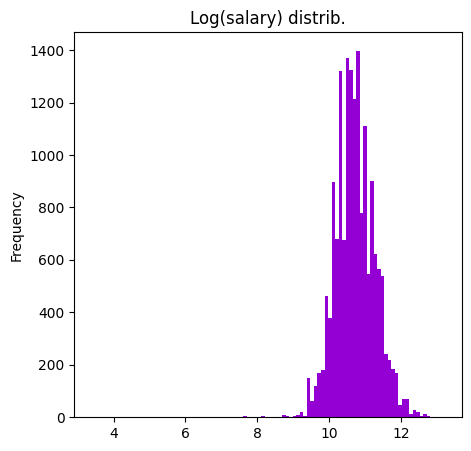

In [6]:
plt.title("Log(salary) distrib.")
train_df['salary'].apply(lambda x: np.log(x)).plot.hist(bins= 100, color='darkviolet', figsize=(5,5));

## Let's proceed to NLP practices:
### The choice and quality of Russian language models is not as good as English ones (one good approach is to translate the text) - which may be done by me in the future or in the end of this notebook, but for now let's use Navec Russian model (usage similar to Gensim, has shown very decent results compared to Ruscorpora etc.). The Navec Hudlit contains around 12B words in most declensions which assumes we can proceed without lemmatizing:

In [7]:
!pip install navec

In [8]:
import navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-01-27 12:32:49--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: 'navec_hudlit_v1_12B_500K_300d_100q.tar.9'

navec_hudlit_v1_12B 100%[===================>]  50.56M  40.2MB/s    in 1.3s    

2024-01-27 12:32:50 (40.2 MB/s) - 'navec_hudlit_v1_12B_500K_300d_100q.tar.9' saved [53012480/53012480]



In [9]:
navecmodel = navec.Navec.load('/kaggle/working/navec_hudlit_v1_12B_500K_300d_100q.tar')

## To tokenize, clean & finally vectorize our text let's define functions:
### Stopwords, punctuation marks, links and derivatives of web junk + removing digits, very short words. Specific English words are not present in NAVEC's corpus, so they'll be cleaned too.

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation

stopwordz = nltk.corpus.stopwords.words("russian")

def remove_links_punc(token):
    token = [i for i in str(token)]
    for j in token:
        if j in punctuation:
            return True
    return False

def tokenize_clean(text): #apply
    text = str(text)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwordz
            and token != ' '
            and len(token) >= 3
            and token.strip() not in punctuation
            and not token.isdigit()
            and not token[0].isdigit()
            and not remove_links_punc(token)]
    text = " ".join(tokens) 
    return text

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [navecmodel[word] for word in words if word in navecmodel]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

### Concating name (position) to descriptions:

In [11]:
for i in range(train_df.shape[0]):
    train_df.iloc[i, 4] = train_df.iloc[i, 0] + " " + train_df.iloc[i, 4]
train_df

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,Водитель-экспедитор Водитель-экспедитор катего...,[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Кладовщик-комплектовщик/оператор 1С Обязанност...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"Продавец магазина ""Магнит"" (Кировский р-он, В....",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Администратор магазина (ТЦ Spar) Крупная федер...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Мойщик посуды (кулинария) Обязанности: Уборка...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Полицейский специального полка полиции Обязанн...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Врач стоматолог-ортопед (г. Новосибирск) Обяза...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Фармацевт Условия: официальное оформление по ...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Геодезист (автодороги) Обязанности: своевреме...,[],75000.0


In [12]:
DESC_tr = train_df[['description', 'salary']]
DESC_tr.tail(5)

,description,salary
16624,Полицейский специального полка полиции Обязанн...,67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск) Обяза...,50000.0
16626,Фармацевт Условия: официальное оформление по ...,50000.0
16627,Геодезист (автодороги) Обязанности: своевреме...,75000.0
16628,Специалист-эксперт отдела правового обеспечени...,25000.0


In [13]:
for i in range(test_df.shape[0]):
    test_df.iloc[i, 5] = test_df.iloc[i, 1] + " " + test_df.iloc[i, 5]
DESC_te = test_df[['id', 'description']]
DESC_te.tail(5)

,id,description
5538,5538,Специалист по дистанционному контролю качества...
5539,5539,Продавец-консультант Компания ONE SMOKE пригла...
5540,5540,Фельдшер скорой медицинской помощи Обязанности...
5541,5541,Продавец-консультант Мечтаешь быть уникальной?...
5542,5542,"Торговый представитель (Колпино, Тосно, Кировс..."


### Applying our functions:

In [14]:
DESC_tr['description'] = DESC_tr['description'].apply(tokenize_clean)
DESC_te['description'] = DESC_te['description'].apply(tokenize_clean)

/tmp/ipykernel_42/674562765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DESC_tr['description'] = DESC_tr['description'].apply(tokenize_clean)
/tmp/ipykernel_42/674562765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DESC_te['description'] = DESC_te['description'].apply(tokenize_clean)


In [15]:
DESC_tr.tail(5)

,description,salary
16624,полицейский специального полка полиции обязанн...,67500.0
16625,врач новосибирск обязанности оказывает квалифи...,50000.0
16626,фармацевт условия официальное оформление графи...,50000.0
16627,геодезист автодороги обязанности своевременное...,75000.0
16628,отдела правового обеспечения обязанности право...,25000.0


### Time to make embeddings out of the text:

In [16]:
X, y = DESC_tr['description'], DESC_tr['salary']
X = np.array([vectorize(sentence) for sentence in tqdm(X)])
X[0].shape

100%|██████████| 16629/16629 [00:22<00:00, 753.36it/s]


(300,)

In [17]:
X.shape

(16629, 300)

In [18]:
from sklearn.model_selection import train_test_split

Xtr, Xtest, Ytr, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtr.shape, Xtest.shape

((13303, 300), (3326, 300))

### As we can see, the default Embedding size is 300. Let's now create a baseline of Catboost Regressor (Gradient Boosting):

In [19]:
import optuna, catboost as cb
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     model = cb.CatBoostRegressor(**params, silent=True)
#     model.fit(Xtr, Ytr)
#     predictions = model.predict(Xtest)
#     r2 = r2_score(Ytest, predictions) #as the final evaluation goes to R^2 score
#     return r2

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

**Trial 21 finished with value: 0.40185431192949694 and parameters: {'learning_rate': 0.049136020014748386, 'depth': 8, 'subsample': 0.6075979443991628, 'colsample_bylevel': 0.06121933518116024, 'min_data_in_leaf': 27}. Best is trial 21 with value: 0.40185431192949694.**

In [21]:
cb_params = {'learning_rate': 0.049136020014748386, 'depth': 8,
             'subsample': 0.6075979443991628, 'colsample_bylevel': 0.06121933518116024,
             'iterations': 1500,
             'min_data_in_leaf': 37}
cb_clf = cb.CatBoostRegressor(**cb_params,
                              eval_metric='R2', silent=True)
cb_clf.fit(Xtr, Ytr)
predictions = cb_clf.predict(Xtest)
r2 = r2_score(Ytest, predictions)
r2

0.40868770221209605

### -- End of the baseline here. R2-score = 0.4086 --
## Let's build a PyTorch network and compare final scores (in the same way using only embeddings from the description).

In [22]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from IPython.display import clear_output

In [23]:
import time
def train_and_val(model, optimizer, criterion, metric_name, train_loader, val_loader,
                  num_epochs, device, Ytest):
    
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    
    metric = r2_score if metric_name == 'r2' else mean_squared_error
        
    for epoch in tqdm(range(1, num_epochs+1)):
        model.train()
        curr_loss, curr_metric = 0, 0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            preds = model(X_batch).squeeze()
            loss = criterion(preds, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric_val = metric(np.array(y_batch.cpu()), np.array(preds.cpu()))
                curr_loss += loss.item() * X_batch.shape[0]
                curr_metric += metric_val * X_batch.shape[0]
                
            if i % 100 == 0:
                clear_output()
                print(f"Curr. loss: {loss.item()}, R^2: {metric_val}, EPOCH {epoch}/{num_epochs}")
                
        train_losses += [curr_loss / len(train_loader.dataset)]
        train_metrics += [curr_metric / len(train_loader.dataset)]
                
        model.eval()
        curr_val_preds = np.array([])
        for i, (X_batch, y_batch) in enumerate(val_loader):
            with torch.no_grad():
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch).squeeze()
                loss = criterion(preds, y_batch)
                curr_val_preds = np.append(curr_val_preds, preds.cpu().numpy())
#                 print(y_batch.cpu()[0], preds.cpu()[0])
#                 print(r2_score(np.array(y_batch.cpu()), np.array(preds.cpu())))
#                 print(curr_metric)
#                 time.sleep(2)
                
                metric_val = metric(np.array(y_batch.cpu()), np.array(preds.cpu()))
                curr_loss += loss.item() * X_batch.shape[0]
                curr_metric += metric_val * X_batch.shape[0]
            
            if i % 100 == 0:
                clear_output()
                print(f"Curr. loss (Validation): {loss.item()},\
                      EPOCH {epoch}/{num_epochs}")
        curr_val_r2 = r2_score(Ytest, curr_val_preds)
        print(f"R^2 (Validation): {curr_val_r2}")
                
        val_losses += [curr_loss / len(val_loader.dataset)]
        val_metrics += [curr_val_r2]
                
    return train_losses, train_metrics, val_losses, val_metrics, curr_val_preds

In [24]:
class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = nn.Linear(300, 256)
        self.a1 = nn.ReLU()
        self.d2 = nn.Linear(256, 128)
        self.a2 = nn.ReLU()
        self.d3 = nn.Linear(128, 64)
        self.a3 = nn.ReLU()
        self.out = nn.Linear(64, 1)
    
    def forward(self, inp):
        x = self.d1(inp)
        x = self.a1(x)
        x = self.d2(x)
        x = self.a2(x)
        x = self.d3(x)
        x = self.a3(x)
        x = self.out(x)
        return x

In [25]:
BATCH_SIZE = 128
EPOCHS = 35
LR = 3e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLPNet()
model.to(DEVICE)

optimizer = torch.optim.AdamW(params = model.parameters(), lr=LR, weight_decay=0.01)
criterion = torch.nn.MSELoss()
tens_train = TensorDataset(
    torch.tensor(Xtr), torch.tensor(np.array(Ytr), dtype=torch.float32)
)
tens_val = TensorDataset(
    torch.tensor(Xtest), torch.tensor(np.array(Ytest), dtype=torch.float32)
)

train_loader = DataLoader(tens_train, batch_size=BATCH_SIZE, num_workers=2)
val_loader = DataLoader(tens_val, batch_size=BATCH_SIZE, num_workers=2)

In [26]:
train_losses, train_metrics, val_losses, val_metrics, predss = train_and_val(model, optimizer, criterion, 'r2', train_loader, val_loader,
                num_epochs=EPOCHS, device=DEVICE, Ytest=Ytest)
train_losses[-1], train_metrics[-1], val_losses[-1], val_metrics[-1]

Curr. loss (Validation): 566668544.0,                      EPOCH 35/35


100%|██████████| 35/35 [00:39<00:00,  1.13s/it]

R^2 (Validation): 0.364170381086413


(692013724.6299331, 0.3946511841897901, 3549978989.623572, 0.364170381086413)

### Best Validation R^2 after selection of the hyperparameters and changing the layers of network = 0.3627. It may a decent value for this task, but it's even lower than the baseline score. That's why we need to change our approach.

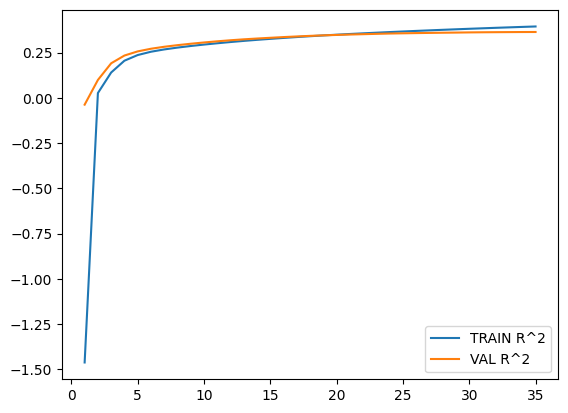

In [27]:
plt.plot(np.arange(1, EPOCHS+1), train_metrics, label='TRAIN R^2')
plt.plot(np.arange(1, EPOCHS+1), val_metrics, label='VAL R^2')
plt.legend();

### * To predict values:

In [28]:
predsv1 = []
metric = r2_score
for i, (X_batch, y_batch) in enumerate(val_loader):
        with torch.no_grad():
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            preds = model(X_batch).squeeze()
            predsv1.append(preds.cpu().numpy())
            loss = criterion(preds, y_batch)

            metric_val = metric(np.array(y_batch.cpu()), np.array(preds.cpu()))


### Let's use everything we have - other columns - they have their own value for this task:

In [29]:
train_df.sample(1)

,name,experience,schedule,employment,description,key_skills,salary
9219,Ведущий медицинский представитель,От 1 года до 3 лет,Полный день,Полная занятость,Ведущий медицинский представитель Лаборатория ...,"['Ориентация на результат', 'Ведение переговор...",100000.0


### Since we decided to use everything, one solution is to use other NLP techniques such as TF-IDF and bag of words, previously lemmatizing tokens.

### For now let's just work with other columns, preserving our Navec-formed embeddings for description as we'll still use them for now.

#### For name: I'll go with lemmatizer (Mystem) and TF-IDF; 
#### For experience, schedule, employment: It's all about classes (we can see that via value_counts()).

In [30]:
df_names_train = train_df['name']
df_names_train

0                                      Водитель-экспедитор
1                      Кладовщик-комплектовщик/оператор 1С
2        Продавец магазина "Магнит" (Кировский р-он, В....
3                         Администратор магазина (ТЦ Spar)
4                                Мойщик посуды (кулинария)
                               ...                        
16624               Полицейский специального полка полиции
16625             Врач стоматолог-ортопед (г. Новосибирск)
16626                                            Фармацевт
16627                               Геодезист (автодороги)
16628      Специалист-эксперт отдела правового обеспечения
Name: name, Length: 16629, dtype: object

In [58]:
df_names_test = test_df['name']
df_names_test

0                                       Главный бухгалтер
1                             Ассистент врача-стоматолога
2                                    Менеджер по продажам
3                                                Менеджер
4                                   Администратор хостела
                              ...                        
5538    Специалист по дистанционному контролю качества...
5539                                 Продавец-консультант
5540                   Фельдшер скорой медицинской помощи
5541                                 Продавец-консультант
5542     Торговый представитель (Колпино, Тосно, Кировск)
Name: name, Length: 5543, dtype: object

In [31]:
!pip install pymystem3

In [32]:
#name
from pymystem3 import Mystem
mm = Mystem()

punctuation = punctuation.join('«—»')
def mystem_lemm(text):
    text = str(text)
    tokens = mm.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stopwordz
            and token != ' '
            and len(token) >= 3
            and token.strip() not in punctuation
            and not token.isdigit()
            and not token[0].isdigit()
            and not remove_links_punc(token)]
    
    text = " ".join(tokens) 
    return text

df_names_train = df_names_train.apply(mystem_lemm)
df_names_train

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


0                                  водитель экспедитор
1                     кладовщик комплектовщик оператор
2                    продавец магазин магнит кировский
3                           администратор магазин spar
4                              мойщик посуда кулинария
                             ...                      
16624             полицейский специальный полк полиция
16625              врач стоматолог ортопед новосибирск
16626                                        фармацевт
16627                             геодезист автодорога
16628    специалист эксперт отдел правовой обеспечение
Name: name, Length: 16629, dtype: object

In [33]:
# df_desc_lemm_train = train_df['description'].apply(mystem_lemm)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

name_tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
# desc_tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
Xtr_names = name_tfidf.fit_transform(df_names_train)
# Xtr_desc_lemm = desc_tfidf.fit_transform(df_desc_lemm_train)

In [35]:
Xtr_names_dense = Xtr_names.toarray()
Xtr_names_dense.shape

(16629, 20311)

### PCA is often useful to help us not to overload the estimator:

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_names = scaler.fit_transform(Xtr_names_dense)

pca = PCA(n_components=100)
X_pca_names = pca.fit_transform(X_scaled_names)

In [37]:
# Xtr_desc_lemm_dense = Xtr_desc_lemm.toarray()
# Xtr_desc_lemm_dense.shape

In [38]:
X2 = np.concatenate((train_df['experience'].to_numpy().reshape(-1,1),
                    train_df['schedule'].to_numpy().reshape(-1,1),
                    train_df['employment'].to_numpy().reshape(-1,1)), axis=1)
X2

array([['От 3 до 6 лет', 'Полный день', 'Полная занятость'],
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость'],
       ['Нет опыта', 'Сменный график', 'Полная занятость'],
       ...,
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость'],
       ['От 1 года до 3 лет', 'Вахтовый метод', 'Полная занятость'],
       ['Нет опыта', 'Полный день', 'Полная занятость']], dtype=object)

In [39]:
X2_final = np.concatenate((X2, X, X_pca_names), axis=1)
X2_final

array([['От 3 до 6 лет', 'Полный день', 'Полная занятость', ...,
        0.027542025642375186, -0.015678903386482142, 0.09165674043837906],
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость', ...,
        0.022066926533555947, -0.014027694387392771,
        -0.01710826854988479],
       ['Нет опыта', 'Сменный график', 'Полная занятость', ...,
        0.9031984636444368, 0.20277720935431853, 0.02848432606265792],
       ...,
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость', ...,
        0.023752560665073582, -0.0016856112816259646,
        0.014067137830279838],
       ['От 1 года до 3 лет', 'Вахтовый метод', 'Полная занятость', ...,
        -0.07031754897394937, -0.07578752500168466, 0.03081448498476088],
       ['Нет опыта', 'Полный день', 'Полная занятость', ...,
        -0.28139070217563195, -0.6819300046856057, -1.8037179474283351]],
      dtype=object)

In [40]:
X2_final.shape

(16629, 403)

In [41]:
# backup_df = pd.DataFrame(X2_final)
# backup_df.to_csv('df_w2v_tf_classes.csv', index=False)

In [42]:
Xtr2, Xtest2, Ytr2, Ytest2 = train_test_split(X2_final, y, test_size=0.2, random_state=42)
Xtr2.shape, Xtest2.shape

((13303, 403), (3326, 403))

In [43]:
#loading the backup from the clean session
# X2_final = pd.read_csv('/kaggle/working/df_w2v_tf_classes.csv')

In [44]:
Ytrain = train_df['salary']

In [45]:
X2_final

array([['От 3 до 6 лет', 'Полный день', 'Полная занятость', ...,
        0.027542025642375186, -0.015678903386482142, 0.09165674043837906],
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость', ...,
        0.022066926533555947, -0.014027694387392771,
        -0.01710826854988479],
       ['Нет опыта', 'Сменный график', 'Полная занятость', ...,
        0.9031984636444368, 0.20277720935431853, 0.02848432606265792],
       ...,
       ['От 1 года до 3 лет', 'Полный день', 'Полная занятость', ...,
        0.023752560665073582, -0.0016856112816259646,
        0.014067137830279838],
       ['От 1 года до 3 лет', 'Вахтовый метод', 'Полная занятость', ...,
        -0.07031754897394937, -0.07578752500168466, 0.03081448498476088],
       ['Нет опыта', 'Полный день', 'Полная занятость', ...,
        -0.28139070217563195, -0.6819300046856057, -1.8037179474283351]],
      dtype=object)

In [46]:
Ytrain

0        42500.0
1        50000.0
2        31500.0
3        36700.0
4        37000.0
          ...   
16624    67500.0
16625    50000.0
16626    50000.0
16627    75000.0
16628    25000.0
Name: salary, Length: 16629, dtype: float64

In [47]:
from sklearn.model_selection import train_test_split

Xtr2, Xtest2, Ytr2, Ytest2 = train_test_split(X2_final, Ytrain, test_size=0.2, random_state=42)
Xtr2.shape, Xtest2.shape

((13303, 403), (3326, 403))

In [54]:
%%time
import optuna
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(Xtr2, Ytr2, cat_features=[0, 1, 2])
    predictions = model.predict(Xtest2)
    r2 = r2_score(Ytest2, predictions) #as the final evaluation goes to R^2 score
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-01-27 12:57:38,684] A new study created in memory with name: no-name-8cde1f10-b5ef-4834-8716-7d5356b37a3a
[I 2024-01-27 12:59:38,890] Trial 0 finished with value: 0.3778380617390744 and parameters: {'learning_rate': 0.0064617331230330975, 'depth': 7, 'subsample': 0.15653445000500488, 'colsample_bylevel': 0.5204157995450267, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.3778380617390744.
[I 2024-01-27 13:09:21,676] Trial 1 finished with value: 0.4396841981388797 and parameters: {'learning_rate': 0.09535870839799873, 'depth': 10, 'subsample': 0.9883455396127122, 'colsample_bylevel': 0.8723113935056414, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.4396841981388797.
[I 2024-01-27 13:11:02,746] Trial 2 finished with value: 0.459509812667658 and parameters: {'learning_rate': 0.09951222346543431, 'depth': 7, 'subsample': 0.8259338163224306, 'colsample_bylevel': 0.34401921628736715, 'min_data_in_leaf': 77}. Best is trial 2 with value: 0.459509812667658.
[I 2024-01-27

CPU times: user 1h 31min 52s, sys: 17min 35s, total: 1h 49min 28s
Wall time: 29min 44s


#### The best result we got here (R^2=0.4595) beats the previous scores (thanks to the features we added), however, we still want more. 
#### So the last approach in the decision of choosing pretrained Word2Vec is here to get everything is possible from Catboost with depth=9:

In [57]:
%%time
import catboost as cb
from sklearn.metrics import r2_score 

cb_params = {'learning_rate': 0.09951222346543431, 'depth': 9, 'subsample': 0.8259338163224306,
            'colsample_bylevel': 0.34401921628736715, 'min_data_in_leaf': 77}
cb_clf = cb.CatBoostRegressor(**cb_params, eval_metric='R2', silent=True)
cb_clf.fit(Xtr2, Ytr2, eval_set=(Xtest2, Ytest2), cat_features=[0, 1, 2])
predictions = cb_clf.predict(Xtest2)
r2 = r2_score(Ytest2, predictions)
r2 
#the depth=7 worked better, {'learning_rate': 0.09951222346543431,
#'depth': 7, 'subsample': 0.8259338163224306, 'colsample_bylevel': 0.34401921628736715, 'min_data_in_leaf': 77}
#is still the best on validation

CPU times: user 11min 2s, sys: 6min 45s, total: 17min 47s
Wall time: 5min 9s


0.45397704000345507

### So, remaining approaches:
* Self-trained Word2Vec
* TF-IDF everything (not using W2V embeddings at all)
* Fine-tuning BERT (ruBERT for our case)

### - In other notebooks

#### Miscellaneous try to build a hybrid neural network below (may be useful):

In [502]:
import time
def train_and_val(model, optimizer, criterion, metric_name, train_loader, val_loader,
                  num_epochs, device, Ytest):
    
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    
    metric = r2_score if metric_name == 'r2' else mean_squared_error
        
    for epoch in tqdm(range(1, num_epochs+1)):
        model.train()
        curr_loss, curr_metric = 0, 0
        for i, (X_tf, X_emb, y_batch) in enumerate(train_loader):
            X_tf, X_emb, y_batch = X_tf.to(device), X_emb.to(device), y_batch.to(device)
            
            preds = model(X_tf, X_emb).squeeze()
            loss = criterion(preds, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric_val = metric(np.array(y_batch.cpu()), np.array(preds.cpu()))
                curr_loss += loss.item() * X_tf.shape[0]
                curr_metric += metric_val * X_tf.shape[0]
                
            if i % 100 == 0:
                clear_output()
                print(f"Curr. loss: {loss.item()}, R^2: {metric_val}, EPOCH {epoch}/{num_epochs}")
                
        train_losses += [curr_loss / len(train_loader.dataset)]
        train_metrics += [curr_metric / len(train_loader.dataset)]
                
        model.eval()
        curr_val_preds = np.array([])
        for i, (X_tf, X_emb, y_batch) in enumerate(val_loader):
            with torch.no_grad():
                X_tf, X_emb, y_batch = X_tf.to(device), X_emb.to(device), y_batch.to(device)

                preds = model(X_tf, X_emb).squeeze()
                loss = criterion(preds, y_batch)
                curr_val_preds = np.append(curr_val_preds, preds.cpu().numpy())
#                 print(y_batch.cpu()[0], preds.cpu()[0])
#                 print(r2_score(np.array(y_batch.cpu()), np.array(preds.cpu())))
#                 print(curr_metric)
#                 time.sleep(2)
                
                metric_val = metric(np.array(y_batch.cpu()), np.array(preds.cpu()))
                curr_loss += loss.item() * X_tf.shape[0]
                curr_metric += metric_val * X_tf.shape[0]
            
            if i % 100 == 0:
                clear_output()
                print(f"Curr. loss (Validation): {loss.item()},\
                      EPOCH {epoch}/{num_epochs}")
        curr_val_r2 = r2_score(Ytest, curr_val_preds)
        print(f"R^2 (Validation): {curr_val_r2}")
                
        val_losses += [curr_loss / len(val_loader.dataset)]
        val_metrics += [curr_val_r2]
                
    return train_losses, train_metrics, val_losses, val_metrics, curr_val_preds

In [503]:
class MLPNetv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.tfidf_branch = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.word2vec_branch = nn.Sequential(
            nn.Linear(300, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.combined_layer = nn.Sequential(
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, tfidf_input, word2vec_input):
        tfidf_output = self.tfidf_branch(tfidf_input)
        word2vec_output = self.word2vec_branch(word2vec_input)

        combined_input = torch.cat((tfidf_output, word2vec_output), dim=1)

        x = self.combined_layer(combined_input)
        return x

In [504]:
from torch.utils.data import Dataset

class HybridDataset(Dataset):
    def __init__(self, tfidf_data, w2v_data, labels):
        self.tfidf_data = tfidf_data
        self.tfidf_desc = tfidf_desc
        self.w2v_data = w2v_data
        self.labels = labels
        
    def __len__(self):
        return len(self.tfidf_data)
    
    def __getitem__(self, idx):
        tfidf_sample = self.tfidf_data[idx]
        tfidf_desc_sample = self.tfidf_desc[idx]
        w2v_sample = self.w2v_data[idx]
        label = self.labels[idx]
        
        return tfidf_sample, tfidf_desc_sample, w2v_sample, label

In [512]:
BATCH_SIZE = 128
EPOCHS = 15
LR = 1e-2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = MLPNetv2()
model2.to(DEVICE)

optimizer = torch.optim.AdamW(params = model2.parameters(), lr=LR, weight_decay=0.01)
criterion = torch.nn.MSELoss()
tens_train_hybrid = HybridDataset(torch.tensor(Xtr2_tf, dtype=torch.float32),
                                  torch.tensor(Xtr2_emb, dtype=torch.float32),
                                  torch.tensor(np.array(Ytr2), dtype=torch.float32))
tens_val_hybrid = HybridDataset(torch.tensor(Xtest2_tf, dtype=torch.float32),
                                torch.tensor(Xtest2_emb, dtype=torch.float32),
                                torch.tensor(np.array(Ytr2), dtype=torch.float32))

train_loader2 = DataLoader(tens_train_hybrid, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader2 = DataLoader(tens_val_hybrid, batch_size=BATCH_SIZE, num_workers=2)

In [513]:
train_losses, train_metrics, val_losses, val_metrics, predss = train_and_val(model2, optimizer, criterion, 'r2',
                train_loader2, val_loader2,
                num_epochs=EPOCHS, device=DEVICE, Ytest=Ytest)
train_losses[-1], train_metrics[-1], val_losses[-1], val_metrics[-1]

Curr. loss (Validation): 1254956288.0,                      EPOCH 15/15


100%|██████████| 15/15 [00:23<00:00,  1.56s/it]

R^2 (Validation): 0.3620075062584317


(717477752.6031722, 0.37489323254806006, 4379212084.502706, 0.3620075062584317)

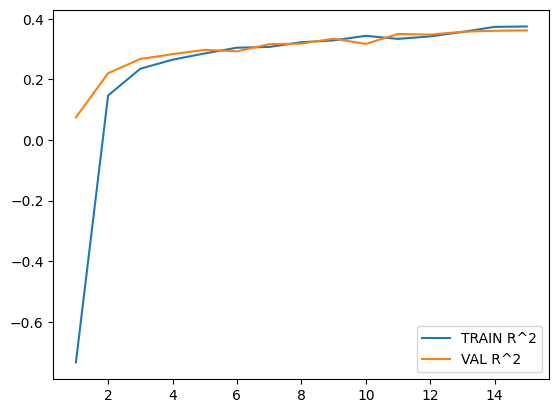

In [514]:
plt.plot(np.arange(1, EPOCHS+1), train_metrics, label='TRAIN R^2')
plt.plot(np.arange(1, EPOCHS+1), val_metrics, label='VAL R^2')
plt.legend();